In [1]:
#@title Data_Processing (Norm, PCA, Redistribution, Augmentation)
import os
from google.colab import drive
drive.mount('/content/drive')
notebook_path = '/content/drive/MyDrive/Berkeley Capstone (Students)/Code/InsDetek3.0_LSTM' # GQ
os.chdir(notebook_path)
# !pwd

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm, trange
from collections import defaultdict
import matplotlib.pyplot as plt
import time
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import random
from IPython.core.pylabtools import figsize
import plotly.graph_objects as go

# Read Data

In [3]:
# df = pd.read_csv('../ExtractedData/weekr4.2.csv')
df = pd.read_csv('../ExtractedData/sessiontime120r4.2.csv') 
# print('weekr4.2.csv', df.shape)
df

,subs_ind,starttime,endtime,user,sessionid,day,week,pc,isworkhour,isafterhour,...,http_leakf_mean_url_len,http_leakf_mean_url_depth,http_leakf_mean_http_c_len,http_leakf_mean_http_c_nwords,http_n_hackf,http_hackf_mean_url_len,http_hackf_mean_url_depth,http_hackf_mean_http_c_len,http_hackf_mean_http_c_nwords,insider
0,0,1.262423e+09,1.262429e+09,10,0,5,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0
1,1,1.262431e+09,1.262436e+09,10,0,5,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0
2,2,1.262438e+09,1.262443e+09,10,0,5,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0
3,3,1.262445e+09,1.262451e+09,10,0,5,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0
4,4,1.262452e+09,1.262456e+09,10,0,5,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1738756,1,1.305539e+09,1.305544e+09,998,7201282,504,72,0,1.0,0.0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0
1738757,2,1.305546e+09,1.305550e+09,998,7201282,504,72,0,1.0,0.0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0
1738758,3,1.305554e+09,1.305557e+09,998,7201282,504,72,0,1.0,0.0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0
1738759,4,1.305563e+09,1.305566e+09,998,7201282,504,72,0,1.0,0.0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0


# EDA

## constant features

[TODO]
figure of constant features # of each time series   (see[Data_Processing-sth](https://colab.research.google.com/drive/11HHrTfFyNWoz3nty8Aw5BvztrhbDT1nt#scrollTo=yxbH4wJADqSD&line=12&uniqifier=1))

## insider distribution

In [4]:
def ins_dist(df, pic=True, height = 500, width = 500, title = None):
    ins = pd.DataFrame()
    ins['len'] = pd.DataFrame(df[['user', 'insider']].groupby('user').count())
    ins['insider_counts']= pd.DataFrame(df[df['insider']!=0][['user', 'insider']].groupby('user').count())
    ins['insider_counts'] = ins['insider_counts'].fillna(0)

    ins.sort_values('insider_counts', ascending = False)
    if pic:
        px.scatter(ins, x='len', y='insider_counts', marginal_x="histogram", marginal_y="histogram", 
                     height = height, width = width, title = title).show()
        # sns.jointplot(ins['len'], ins['insider_counts'], data=None, kind='scatter', marginal_kws=dict(bins=72, fill=True))
    return ins

# Example
# ins_df = ins_dist(df,title = 'weekr4.2.csv')

## user-week scatter

In [21]:
def user_week_plot(df_input, width=None, height=None, title = None):
    df = df_input.copy()
    df['insider'] = df['insider'].astype(str)
    user_list = sorted(list(df['user'].unique()))
    df['users (reset idx)'] = df['user'].apply(lambda x: user_list.index(x))

    c = ['rgb(141, 211, 199)', 'rgb(237, 100, 90)', 'rgb(47, 138, 196)', 'rgb(230, 171, 2)']
    fig = px.scatter(df, x='sessionid', y='users (reset idx)', hover_name='user',
            color = 'insider', color_discrete_sequence=c, width=width, height = height, title = title)
    fig.update_traces(marker_size = 3)
    fig.show()

# Example
# user_week_plot(df, 600, 600, 'weekr4.2.csv')

## insider types

In [6]:
def ins_types(df):
    user_ins_type = df.groupby('user')['insider'].agg([lambda x: x[x==0].count(), 
                                        lambda x: x[x==1].count(), 
                                        lambda x: x[x==2].count(), 
                                        lambda x: x[x==3].count()])
    print("== {0} users ==".format(len(df['user'].unique())))
    print('clean users', len(user_ins_type[user_ins_type[['<lambda_1>','<lambda_2>','<lambda_3>']].sum(axis=1) == 0]))
    print('insider 1 users', len(user_ins_type[user_ins_type['<lambda_1>'] != 0]))
    print('insider 2 users', len(user_ins_type[user_ins_type['<lambda_2>'] != 0]))
    print('insider 3 users', len(user_ins_type[user_ins_type['<lambda_3>'] != 0]))

In [8]:
ins_types(df)
# user_week_plot(df, 600, 600)

== 1000 users ==
clean users 930
insider 1 users 70
insider 2 users 0
insider 3 users 0


In [12]:
# combine insider label
df.loc[df['insider'].isin([2,3]),'insider'] = 1
print('new data shape: {0} with {1:.2%} insider activities:\n'.format(df.shape, df['insider'].sum()/df['insider'].count()), end='')
print(pd.DataFrame(df['insider'].value_counts()))

new data shape: (1738761, 129) with 0.18% insider activities:
   insider
0  1735565
1     3196


In [ ]:
user_week_plot(df, 600, 600)

# Data Augmentation

## redistribution (delete majority)

In [ ]:
ins_df

,insider_counts,len
user,,
4,1,61
11,1,69
28,1,41
30,1,47
31,2,56
...,...,...
904,9,43
927,8,55
969,2,31


In [9]:
ins_df = ins_dist(df)

In [ ]:
# distribution of len(clean data)

# ins_0_not72 = ins_df[(ins_df['insider_counts'] == 0)&(ins_df['len'] != 72)]
# px.histogram(ins_0_not72, x = 'len', nbins = 72) # from the fig, we chose to delete ones with len < 15

# ins_df[ins_df['len'] == 72] # 845 users with (72, 0)
# ins_df[(ins_df['insider_counts'] == 0)&(ins_df['len'] != 72)] # 85 users with (not 72, 0)
# ins_df[(ins_df['insider_counts'] == 0)&(ins_df['len'] < 15)].shape # 19 users with (<15, 0)

In [8]:
ins_df = ins_dist(df, False)
user_del = list(ins_df[(ins_df['len'] == 72)|(ins_df['len'] < 15)].index)

df_redist = df[~df['user'].isin(user_del)]
print('deleted {0} users, {1} users left'.format(len(user_del), df_redist['user'].unique().shape[0]))
ins_df_del = ins_dist(df_redist, False)
# ins_df = ins_dist(df_deleted) # joint plot before

deleted 0 users, 1000 users left


## shortening

[Q] I'm reaaally not sure if this will work. Seems like it just lower the variance of the sequences' length

In [13]:
df_redist = df

In [9]:
def shorten_seq(df, rate=0.3):
    short = []
    for u in df['user'].unique():
        start = int(len(df[df['user'] == u]) * rate)
        short += list(df[df['user'] == u].iloc[start:,:].index)
    # user_week_plot(df_short, 600, 600)
    return df.loc[short,:]

In [16]:
df_short = shorten_seq(df_redist, 0.7)
# user_week_plot(df_short, 600, 600)

In [17]:
ins_df_short = ins_dist(df_short)

In [ ]:
user_week_plot(df)

## augmentation (slide window)

* index is no longer unique after data augmentation

In [ ]:
def slide_window(df_input, dist = 'uni', info = False, rand_l = 25, rand_h = 35
                 , mean = 27, scale = 5, lim = (10,35)):
    # the default value for 'mean', 'scale' and 'lim' are set by shortened data

    # OPT 1 Uniform Distribution U[30-5, 30+5]
    # [TODO] OPT 3 
        #probability of each insider_counts' length?
        # df_week.groupby('user').count().mean() # = 45.323529
        # seq_len = random.randint(30, 60)

    df = df_input.copy()
    n_user = len(df['user'].unique())
    ins_df_input = ins_dist(df_input, pic = False)
    n_ins_user = len(ins_df_input[ins_df_input['insider_counts']!=0])
    n_ins = ins_df_input['insider_counts'].sum()
    print("== processing {0} activities ({3:.2%} ins) of {1} users ({2} ins) ==".format(len(df), n_user, n_ins_user, n_ins/len(df)))
    bar = tqdm(enumerate(df['user'].unique()), total = n_user)
    random.seed(1)

    for i, u in bar: # for each user's sequence

        seq = df[df['user'] == u].copy()
        ano_idx = list(seq[seq['insider'] == 1].index) # indexes of all anomaly activities
        add = pd.DataFrame()

        for note, end in enumerate(ano_idx): # use `while seq['insider'].sum() will be faster?`
            for repeat in range(3):

                if dist == 'norm':
                    seq_len = 0
                    while seq_len < lim[0] or seq_len > lim[1]:
                        seq_len = int(np.random.normal(mean, scale, 1))
                else:
                    seq_len = random.randint(rand_l, rand_h) # select variable length

                new_seq = seq.loc[: end][-seq_len:].copy() # last 'seq_len' points of sequence ends at 'end'
                new_seq['user'] += 0.1 * (note+1) + 0.01 * (repeat+1) # max(insider_counts) < 10, so *0.1 is ok
                df = df.append(new_seq)

        bar.set_description("{2} activities of {3} users (user {0}: added {1} new users)".format(u, len(ano_idx), len(df), len(df['user'].unique())))
        if info:
            print("{2} activities of {3} users (user {0}: added {1} new users)".format(u, len(ano_idx), len(df), len(df['user'].unique())))

    return df

In [ ]:
df_aug = slide_window(df_short, 'norm') # shortened, normal dist
# df_aug.to_csv('data/df_aug_sh_normal.csv', index_label = 'idx')
ins_df_aug = ins_dist(df_aug)
print('new data shape: {0} with {1:.2%} insider activities:\n'.format(df_aug.shape, df_aug['insider'].sum()/df_aug['insider'].count()), end='')
print(pd.DataFrame(df_aug['insider'].value_counts()))
print('and {0:.2%} insider users:\n'.format(len(ins_df_aug[ins_df_aug['insider_counts']!=0])/len(df_aug['user'].unique())), end='')
print(pd.DataFrame(df_aug['insider'].value_counts()))

== processing 4379 activities (7.22% ins) of 136 users (70 ins) ==


  0%|          | 0/136 [00:00<?, ?it/s]

new data shape: (26785, 668) with 15.66% insider activities:
   insider
0    22590
1     4195
and 93.91% insider users:
   insider
0    22590
1     4195


In [ ]:
user_week_plot(df_aug, 600, 600)

## experiments

In [ ]:
df_aug = slide_window(df_del)

== processing 6164 activities of 136 users ==


  0%|          | 0/136 [00:00<?, ?it/s]

In [ ]:
df_aug_sh = slide_window(df_short)

== processing 4379 activities of 136 users ==


  0%|          | 0/136 [00:00<?, ?it/s]

In [ ]:
user_week_plot(df_aug, 600, 600)
user_week_plot(df_aug_sh, 600, 600)

In [ ]:
# uniform
_ = ins_dist(df_aug)
_ = ins_dist(df_aug_sh)

In [ ]:
# normal
df_aug_normal = slide_window(df_del, 'norm')
_ = ins_dist(df_aug_normal)
df_aug_sh_normal = slide_window(df_short, 'norm')
_ = ins_dist(df_aug_sh_normal)

== processing 6164 activities of 136 users ==


  0%|          | 0/136 [00:00<?, ?it/s]

== processing 4379 activities of 136 users ==


  0%|          | 0/136 [00:00<?, ?it/s]

In [ ]:
ins_df_short

,insider_counts,len
user,,
4,1,43
11,1,49
14,0,16
19,0,13
26,0,17
...,...,...
969,2,22
975,2,33
983,1,42


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



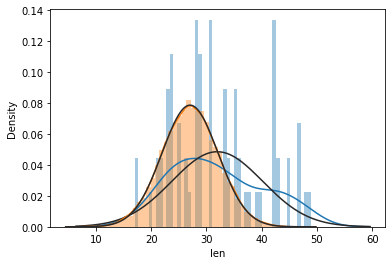

In [ ]:
# # Finding mean & var for normal dist
from scipy import stats
sns.distplot(ins_df_short[ins_df_short['insider_counts']!=0].len, bins = 50, fit = stats.norm)
sns.distplot(np.random.normal(27, 5, 10000), fit = stats.norm)

# Proving that call np.random.normal one time and each time is the same 
    # temp = []
    # for i in range(10000):
    #     temp.append(np.random.normal(30, 9.5, 1))
    # sns.distplot(temp, fit = stats.norm)
    # sns.distplot(np.random.normal(30, 9.5, 10000), fit = stats.norm)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



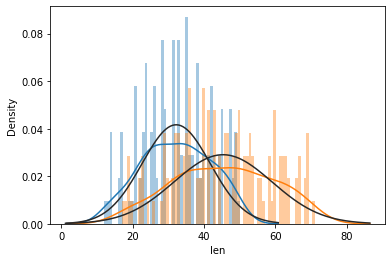

In [ ]:
# sns.distplot(ins_df_short.len, bins = 50, fit = stats.norm)
# sns.distplot(ins_df_del.len, bins = 70, fit = stats.norm)

# Delete Features

1. <h4>Delete features that has the same value throughtout the whole dataset.<h/>
2. <h4>Delete features about user information (common constant features among all time series)<h/>    

&emsp;&emsp;&emsp; _Each time series has many constant features, but overlap is small_ (see 'EDA - constant features')



In [14]:
df_aug = df

In [15]:
def del_const_fea(input_df):

    # 1. delete features that has the same value
    df = input_df.copy()
    del_col = set()
    for i in range(df.shape[1]):
        if len(df.iloc[:,i].value_counts()) == 1:
            del_col.add(df.columns[i])
    df = df.drop(columns = del_col)

    # 2. delete user info features
    user_info = ['starttime','endtime', 'A', 'C', 'E', 'ITAdmin', 'N', 'O', 'dept', 'f_unit', 'role', 'team'] # keep 'week'
    df = df.drop(columns = user_info)   



    return df, set(del_col | (set(user_info)))


df_deleted, del_col = del_const_fea(df_aug)
print('deleted {0} constant features on activities, saved in del_col'.format(len(del_col)))
print('new data shape: {0}'.format(df_deleted.shape))

deleted 26 constant features on activities, saved in del_col
new data shape: (1738761, 103)


3. <h4>Delete features that has over 98% same value throughtout the whole dataset. And when the feature is the other values, the label is still 0. (We assume this feature won't contribute to the label, or irrelevant) <h/>

In [16]:
li = df_deleted.apply(lambda x: x.value_counts().values[0]/len(df_aug)).sort_values()
li = li[li > 0.98]
print("found",len(li), "features with over 98% same value")
idx = list(li.index)
feat_counts = pd.DataFrame({'counts':df_deleted[idx].apply(lambda x: len(x.unique())).sort_values()})

dull_fea = []
for fea in list(feat_counts.index):
    v_cnt = df_deleted[fea].value_counts()
    minority = df_deleted[df_deleted[fea] != v_cnt.index[0]]['insider']
    if minority.sum() == 0:
        dull_fea.append(fea)
        # print("{0} anomaly activities in the minority({1} activities) of this feature".format(minority.sum(), minority.count()))
print("found",len(dull_fea), "features with over 98% same value, and other values are irrelvant with 'insider'")

df_deleted = df_deleted.drop(dull_fea, axis = 1)
df_deleted.shape

found 48 features with over 98% same value
found 4 features with over 98% same value, and other values are irrelvant with 'insider'


(1738761, 99)

# Normalization

Two options on normalization:
1.   Norm on the whole dataset
2.   Norm on each time series



In [17]:
# 1. norm on whole dataset
df_norm = df_deleted.copy()
col_list = list(set(df_norm.columns) - set(['user','week','insider']))
df_norm[col_list] = df_norm[col_list].apply(lambda col: (col-col.mean())/col.std())
df_norm.to_csv('data/data_3.1.csv', index=True, index_label='idx')

# # 2. norm by user 
    # df = df_deleted.copy() 
    # df_new = pd.DataFrame()
    # for u in df['user'].value_counts().index:
    #     df_user = df.loc[df['user']==u].copy()
    #     for idx, std in df_user.iloc[:,1:-1].std().items():
    #         if std == 0:
    #             df_user[idx] = 0 # [Q] Constant features norm: zero?
    #         else:
    #             df_user[idx] = (df_user[idx]-df_user[idx].mean())/std
    #     df_new = df_new.append(df_user)

In [ ]:
df_norm = pd.read_csv('data/data_4.1.csv', index_col='idx')

# PCA (not suggested)

In [ ]:
fig = go.Figure()
corr = df_norm.corr()
fig.add_trace(go.Heatmap(z = np.array(corr), x = corr.columns, y = corr.columns))
fig.update_layout(autosize=False, width=1000, height=1000)

Output hidden; open in https://colab.research.google.com to view.

## statistical tests

In [ ]:
# !pip install factor_analyzer

print('Bartlett Sphericity Test')
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
chi_square_value,p_value=calculate_bartlett_sphericity(df_norm[col_list])
print('Chi-square：',chi_square_value,'P value', p_value)

# must > 0.6
from factor_analyzer.factor_analyzer import calculate_kmo
kmo_all,kmo_model=calculate_kmo(df_norm[col_list])
print('KMO：',kmo_model)

Bartlett Sphericity Test


/usr/local/lib/python3.7/dist-packages/factor_analyzer/factor_analyzer.py:111: RuntimeWarning:

divide by zero encountered in log



Chi-square： inf P value 0.0


/usr/local/lib/python3.7/dist-packages/factor_analyzer/utils.py:249: UserWarning:

The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.



KMO： 0.5243440245936265


## pca

In [ ]:
from sklearn.decomposition import PCA
n_components = 200
pca = PCA(n_components)

pca.fit(df_norm[col_list])
# Deleted 'user' col, otherwise user can be the factor to explain nearly 100%
pca_var = pca.explained_variance_ratio_
print(pca_var[:10])
px.bar(np.cumsum(pca_var))

[0.13774598 0.07372026 0.05643508 0.0486465  0.04628783 0.03603323
 0.02889021 0.02733964 0.02668126 0.02595312]


In [ ]:
weights = pd.DataFrame(pca.components_[0:180], columns = df_norm[col_list].columns, index = ['Factor '+str(i) for i in range(180)]) # 99.8966%

,file_docf_n-disk1,workhourfile_txtf_n-disk0,workhourfile_n_phof,workhourfile_phof_n-disk1,afterhouremail_mean_n_bccdes,afterhourhttp_n_otherf,afterhouremail_mean_n_atts,http_n_hackf,file_exef_n-disk0,file_phof_mean_file_nwords,...,afterhouremail_n-pc0,weekendlogon_n-pc0,afterhourfile_n-pc2,weekendhttp_n_leakf,afterhourusb_n-pc0,afterhourusb_mean_usb_dur,file_exef_n-pc0,afterhourhttp_otherf_n-pc2,workhouremail_mean_n_atts,file_exef_mean_file_nwords
Factor 0,0.093293,0.094863,0.095269,0.033274,0.006787,0.011913,0.007730,0.003865,0.071152,0.032901,...,0.009211,0.056302,0.041713,0.001289,0.043287,-0.069788,0.069305,0.000543,0.014818,0.069824
Factor 1,0.042738,0.050159,0.048809,0.015832,-0.000225,-0.004585,-0.000359,0.008206,0.038973,0.017999,...,-0.003241,-0.122481,0.063336,0.000387,0.036458,-0.053873,0.033361,0.003560,0.000369,0.040665
Factor 2,-0.006861,-0.006574,-0.007287,-0.002622,-0.037904,0.011374,-0.015231,0.007725,-0.003886,-0.001335,...,0.005748,-0.035030,0.030891,-0.002684,-0.013736,0.012211,-0.008114,0.003992,-0.002998,-0.002977
Factor 3,-0.005162,-0.012237,-0.011512,-0.003760,-0.155988,-0.167246,-0.065834,0.013540,-0.000635,-0.001701,...,-0.146809,0.020178,0.067211,-0.001866,-0.040644,0.020201,-0.009820,0.008913,0.002751,-0.000127
Factor 4,-0.036931,-0.070299,-0.068431,-0.024792,0.057353,0.060933,0.023357,0.049189,-0.031293,-0.007670,...,0.050773,0.037745,0.145544,0.008313,0.014709,-0.053199,-0.052218,0.028359,0.002212,-0.028947
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Factor 175,0.000636,0.001129,0.000080,-0.000943,-0.019538,-0.002845,-0.002146,0.000426,-0.078617,-0.005455,...,0.035762,-0.001618,-0.001346,0.000778,-0.006664,-0.001659,0.034649,0.000039,-0.022721,-0.109149
Factor 176,0.002303,0.001707,0.002505,0.000114,-0.011372,0.000023,-0.000237,-0.000211,-0.450671,0.008061,...,0.050495,-0.001335,0.001248,0.000431,-0.000785,-0.001775,0.245199,0.000032,0.001632,0.242195
Factor 177,-0.000704,-0.002495,-0.000439,-0.000242,-0.041618,-0.008472,0.003210,0.000445,0.091380,-0.007944,...,0.278889,-0.001260,-0.001803,-0.001735,-0.018706,0.003691,-0.049653,-0.000098,0.016424,-0.037607
Factor 178,-0.000025,0.004825,-0.001466,0.000169,-0.141859,0.003159,0.105097,-0.000878,0.001347,0.002849,...,-0.066456,-0.006970,0.000297,0.000443,0.002803,0.002045,-0.000766,0.000398,0.596051,0.002904


In [ ]:
px.imshow(weights, x=list(range(443)))

In [ ]:
df_pca = pd.DataFrame(np.dot(df_norm, weights.T), columns = weights.index)
df_pca['insider'] = df['insider']
df_pca = pd.concat([df['user'], df_pca], axis=1)
df_pca.head()

# [TODO] Shuffle

In [ ]:
df